In [2]:
!pip install datasets
!pip install clean-text
!pip install transformers
!pip install sentencepiece
!pip install nlpaug
!pip install googletrans==3.1.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 11.4 MB/s eta 0:

In [3]:
import pandas as pd
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import re
from cleantext import clean
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import torch
from sklearn.metrics import f1_score
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import nlpaug.augmenter.word as naw
import googletrans
from googletrans import Translator
import numpy as np

In [4]:
dataset = pd.read_csv("../datasets/subtaskB_train.csv")
dataset = dataset.drop('Id', axis=1)
dataset = dataset.drop('topic', axis=1)
dataset = dataset.rename(columns={'comment_text': 'text', 'conspiracy': 'label'})
dataset

,text,label
0,"Siamo davanti ad una prova, e non solo di quoz...",1
1,La storia dei 2 bimbi di Bergamo - vaccini: qu...,0
2,L'avete capito che non toglieranno il green pa...,0
3,Quindi la farsa dello spazio e della terra a ...,3
4,"In breve tempo, per accedere a Internet, sarà ...",1
...,...,...
805,"Incredibile!!!! EMA, Agenzia Europea del Farma...",0
806,Non ci saranno colloqui di pace con la Russia ...,2
807,"L'atmosfera è uno ""scudo protettivo"" che avvol...",3
808,OTTIMA NOTIZIA! Due ragioni per cui le élite n...,0


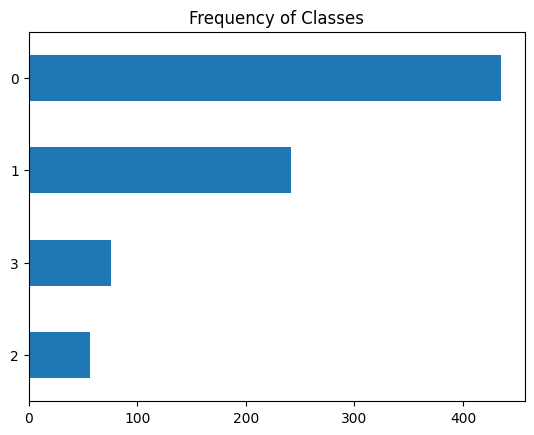

In [5]:
dataset['label'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [5]:
# We define the function for the cleaning of the text

def text_cleaning(text):
    # Convert words to lower case
    text = text.lower()
    text = clean(text, no_emoji=True)

    text = re.sub(r'(\[.*?\])', '', text)
    text = re.sub(r'[0-9]{2}\/[0-9]{2}\/[0-9]{2,4}', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'[_"\()|+&=*%#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\.+','.', text)
    text = re.sub(r'\,+',',', text)
    text = re.sub(r'\!+','!', text)
    text = re.sub(r'\?+','?', text)
    text = re.sub(r'\n+','', text)
    text = re.sub(r' +', ' ', text)
    text = re.sub('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text)

    return text

In [6]:
dataset['text'] = list(map(text_cleaning, dataset.text))
dataset

,text,label
0,"siamo davanti ad una prova, e non solo di quoz...",1
1,la storia dei 2 bimbi di bergamo - vaccini: qu...,0
2,l'avete capito che non toglieranno il green pa...,0
3,quindi la farsa dello spazio e della terra a p...,3
4,"in breve tempo, per accedere a internet, sara ...",1
...,...,...
805,"incredibile! ema, agenzia europea del farmaco,...",0
806,non ci saranno colloqui di pace con la russia ...,2
807,l'atmosfera e uno scudo protettivo che avvolge...,3
808,ottima notizia! due ragioni per cui le elite n...,0


In [7]:
model_name = 'dbmdz/bert-base-italian-xxl-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [9]:
# We controll if the device support the computation on the GPU, otherwise we will compute the model on the CPU
device = ('cuda' if torch.cuda.is_available() else 'cpu')

num_labels = 4  # Number of classes
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification

In [10]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    return {'f1_score': f1}

In [11]:
def createDataset(train, val):
  tds = Dataset.from_pandas(train)
  vds = Dataset.from_pandas(val)
  dataset_hf = DatasetDict()
  
  dataset_hf['train'] = tds
  dataset_hf['validation'] = vds
  dataset_hf['train']= dataset_hf['train'].remove_columns("__index_level_0__")
  dataset_hf['validation']= dataset_hf['validation'].remove_columns("__index_level_0__")

  return dataset_hf

In [12]:
back_translation_aug = naw.BackTranslationAug(
    from_model_name='Helsinki-NLP/opus-mt-it-en',
    to_model_name='Helsinki-NLP/opus-mt-en-it', device='cuda', max_length=512)
estensione = back_translation_aug.augment(list(dataset.loc[dataset['label'] != 0]['text']))

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [13]:
# function to translate text to another language and back to the original language
def back_translationGoogle(text):
    translator = Translator()
    translation = translator.translate(text, dest='fr').text
    translation = translator.translate(translation, dest='it').text
    return translation

extension = []
for text in dataset.loc[dataset['label'] > 1]['text']:
  extension.append(back_translationGoogle(text))

extension

["così la farsa dello spazio e della terra in mongolfiera continua con i suoi finti viaggi lunari e marziani. per il motivo che sono finanziati da miliardi di dollari. economicamente. mentre lanciano un razzo che è poi destinato a cadere nell'oceano. o atterrare in un'unica base. le persone poi ci cascano perché dopo aver visto il vero lancio, poi guardano un film realizzato nello stesso studio in cui producono i film Marvel. dove con la realtà virtuale possono fare quello che vogliono!",
 "se l'aspetto di questo pianeta influisce sul genio alieno che chiamiamo sole. e la luna. ovviamente sarà cavolo per tutti",
 'visto che hanno dovuto rifare la finta Antartide. farne un palo',
 'attenzione quindi a tutte le reazioni e risposte di aldrin che ovviamente difende la sua icona, ma in compenso si giustifica.',
 'attenzione che la nasa ha generalmente minimizzato e oscurato tutti i diversi avvisi come tutti i governi.',
 "c'è ancora chi crede che grazie ai satelliti ci sia il gps. falseoo 3

In [14]:
df_extension1 = pd.DataFrame(estensione, columns=['text'])
df_extension1['label'] = dataset.loc[dataset['label'] != 0]['label'].reset_index().drop('index', axis=1)
df_extension1

,text,label
0,"ci troviamo di fronte a una prova, e non solo ...",1
1,Così la farsa dello spazio e del calcio terra ...,3
2,In breve tempo sarà necessario un documento di...,1
3,se come questo pianeta sembra influenzare il c...,3
4,di Brian cates dall'incredibilmente accurata a...,1
...,...,...
370,"è chiaro, non è che la frode del mulo è l'unic...",1
371,Abraccia la terra spesso 2000 km oooh mi ricor...,3
372,Non ci saranno colloqui di pace con la Russia ...,2
373,L'atmosfera e uno scudo protettivo che circond...,3


In [15]:
df_extension2 = pd.DataFrame(extension, columns=['text'])
df_extension2['label'] = dataset.loc[dataset['label'] > 1]['label'].reset_index().drop('index', axis=1)
df_extension2

,text,label
0,così la farsa dello spazio e della terra in mo...,3
1,se l'aspetto di questo pianeta influisce sul g...,3
2,visto che hanno dovuto rifare la finta Antarti...,3
3,attenzione quindi a tutte le reazioni e rispos...,3
4,attenzione che la nasa ha generalmente minimiz...,3
...,...,...
128,povero zelenskya rete4 l'hanno fatto neroecco ...,2
129,avvolge la terra con uno spessore di 2000 km,3
130,Non ci saranno colloqui di pace con la Russia ...,2
131,l'atmosfera è uno scudo protettivo che circond...,3


In [16]:
df_extended = pd.concat([dataset, df_extension1, df_extension2])
df_extended

,text,label
0,"siamo davanti ad una prova, e non solo di quoz...",1
1,la storia dei 2 bimbi di bergamo - vaccini: qu...,0
2,l'avete capito che non toglieranno il green pa...,0
3,quindi la farsa dello spazio e della terra a p...,3
4,"in breve tempo, per accedere a internet, sara ...",1
...,...,...
128,povero zelenskya rete4 l'hanno fatto neroecco ...,2
129,avvolge la terra con uno spessore di 2000 km,3
130,Non ci saranno colloqui di pace con la Russia ...,2
131,l'atmosfera è uno scudo protettivo che circond...,3


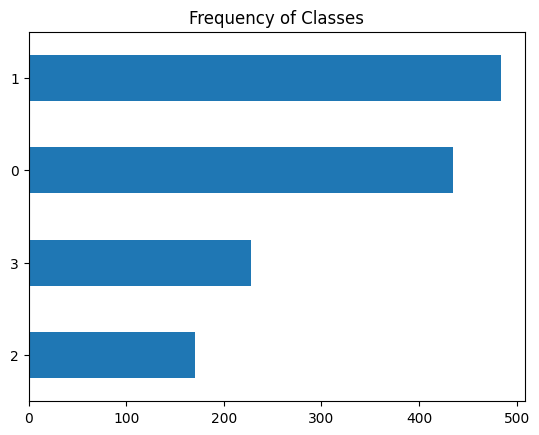

In [17]:
df_extended['label'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [18]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
lr_rates = [2e-5, 3e-5]
epochs = [2,3,4]
lr_scheduler = ['constant']

log_results_cross = pd.DataFrame({
    'learning_rate': [],
    'epochs': [],
    'f1_score': [],
    'lr_scheduler': []
})

for lr in lr_rates:
  for epoch in epochs:
    for scheduler in lr_scheduler:
      results = []

      for i in range(3):
        # We create the split of the dataset, shuffling before the data
        train, val = train_test_split(df_extended, train_size=0.8, shuffle=True)
        df = createDataset(train, val)
        texts_encoded = df.map(tokenize, batched=True, batch_size=None)

        # We define the argument that the model has to use
        batch_size = 8
        logging_steps = len(texts_encoded['train'])
        model_name_hub = f'{model_name}-kcross'
        training_args = TrainingArguments(output_dir=model_name,
                                    num_train_epochs=epoch,
                                    learning_rate=lr,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    evaluation_strategy='epoch',
                                    disable_tqdm=False,
                                    logging_steps=logging_steps,
                                    #lr_scheduler_type=scheduler,
                                    fp16=True,
                                    push_to_hub=False,
                                    log_level='error')
        # Train of the model
        trainer = Trainer(model=model,
                    args=training_args,
                    compute_metrics=compute_metrics,
                    train_dataset=texts_encoded['train'],
                    eval_dataset=texts_encoded['validation'],
                    tokenizer=tokenizer)
        trainer.train()
        results.append(trainer.predict(texts_encoded['validation']).metrics['test_f1_score'])
    
    # We calculate the mean of the f1_scores and we save the model and the result on a log
    mean_f1_score = sum(results) / len(results)
    print(mean_f1_score)

    # We log the actual parameters and the mean f1_score
    parameters = [lr, epoch, mean_f1_score, scheduler]
    log_results_cross.loc[len(log_results_cross)] = parameters
  
log_results_cross.to_csv('/log/log_cross_xxl_new_aug_1.csv')

Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.366047,0.892586
2,No log,0.261985,0.912148


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.206876,0.950622
2,No log,0.178675,0.954418


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.269109,0.946795
2,No log,0.196722,0.969710


0.945425230925669


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.280426,0.958275
2,No log,0.420935,0.943124
3,No log,0.329683,0.947071


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.363035,0.950551
2,No log,0.632028,0.931160
3,No log,0.276326,0.958342


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.344260,0.958250
2,No log,0.363882,0.950611
3,No log,0.384553,0.950611


0.9520082743824467


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.411647,0.950611
2,No log,0.425496,0.950611
3,No log,0.433965,0.950611
4,No log,0.461679,0.954369


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.473988,0.954369
2,No log,0.474700,0.954369
3,No log,0.470477,0.954369
4,No log,0.472668,0.954369


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.474662,0.954369
2,No log,0.477462,0.954369
3,No log,0.473981,0.954369
4,No log,0.476429,0.954369


0.954369155933521


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.476830,0.954369
2,No log,0.476216,0.954369


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.476621,0.954369
2,No log,0.476453,0.954369


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.476293,0.954369
2,No log,0.475909,0.954369


0.954369155933521


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.475850,0.954369
2,No log,0.475459,0.954369
3,No log,0.474804,0.954369


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.475147,0.954369
2,No log,0.474967,0.954369
3,No log,0.474826,0.954369


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.476126,0.954369
2,No log,0.475211,0.954369
3,No log,0.475246,0.958291


0.9556763838312724


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.475662,0.954369
2,No log,0.475586,0.958291
3,No log,0.475619,0.958291
4,No log,0.478129,0.958291


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.478464,0.958291
2,No log,0.478715,0.958291
3,No log,0.479363,0.958291
4,No log,0.480670,0.958291


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.481938,0.958291
2,No log,0.482738,0.958291
3,No log,0.484065,0.958291
4,No log,0.484193,0.958291


0.9582908396267752


In [19]:
train, val = train_test_split(df_extended, train_size=0.8, shuffle=True)
dataset_final_train = createDataset(train, val)
dataset_final_encoded = dataset_final_train.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

In [23]:
# We take the best parameter from the log
idx_best_model = log_results_cross['f1_score'].idxmax()
learning_rate_best = log_results_cross['learning_rate'][idx_best_model]
epoch_best = float(log_results_cross['epochs'][idx_best_model])
#lr_scheduler_best = log_results_cross['lr_scheduler'][idx_best_model]

print(f'The learning rate of the best model is: {learning_rate_best}')
print(f'The number of epochs of the best model is: {epoch_best}')

# We define the arguments for the training 
batch_size = 8
logging_steps = len(dataset_final_encoded['train'])
model_name_hub = 'best-xxl-multiCls-4'

# We train the final model
training_args = TrainingArguments(output_dir=model_name_hub,
                                  num_train_epochs=epoch_best,
                                  learning_rate=learning_rate_best,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  #lr_scheduler_type=lr_scheduler_best,
                                  fp16=True,
                                  push_to_hub=True,
                                  log_level='error')

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_final_encoded['train'],
                  eval_dataset=dataset_final_encoded['validation'],
                  tokenizer=tokenizer)
trainer.train()
trainer.push_to_hub()

The learning rate of the best model is: 3e-05
The number of epochs of the best model is: 2


/content/best-xxl-multiCls-4 is already a clone of https://huggingface.co/Mike00vito/best-xxl-multiCls-4. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.619737,0.916329
2,No log,0.544445,0.924035


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/422M [00:00<?, ?B/s]

Upload file runs/Apr30_16-13-34_246af645f1cc/events.out.tfevents.1682871217.246af645f1cc.473.4:   0%|         …

Upload file runs/Apr30_16-13-34_246af645f1cc/1682871217.5136354/events.out.tfevents.1682871217.246af645f1cc.47…

Upload file runs/Apr30_16-10-55_246af645f1cc/1682871058.4066167/events.out.tfevents.1682871058.246af645f1cc.47…

Upload file training_args.bin:   0%|          | 1.00/3.50k [00:00<?, ?B/s]

Upload file runs/Apr30_16-10-55_246af645f1cc/events.out.tfevents.1682871058.246af645f1cc.473.2:   0%|         …

To https://huggingface.co/Mike00vito/best-xxl-multiCls-4
   b4c7689..67294c9  main -> main

   b4c7689..67294c9  main -> main

To https://huggingface.co/Mike00vito/best-xxl-multiCls-4
   67294c9..08092ae  main -> main

   67294c9..08092ae  main -> main



'https://huggingface.co/Mike00vito/best-xxl-multiCls-4/commit/67294c98196086b652d99b08deb68454d1141b4e'